## Environment preparation

Google Cloud Platform was used for this project.

A bucket was created.

The file my_actions.sh was uploaded to the master node and copied into the bucket.

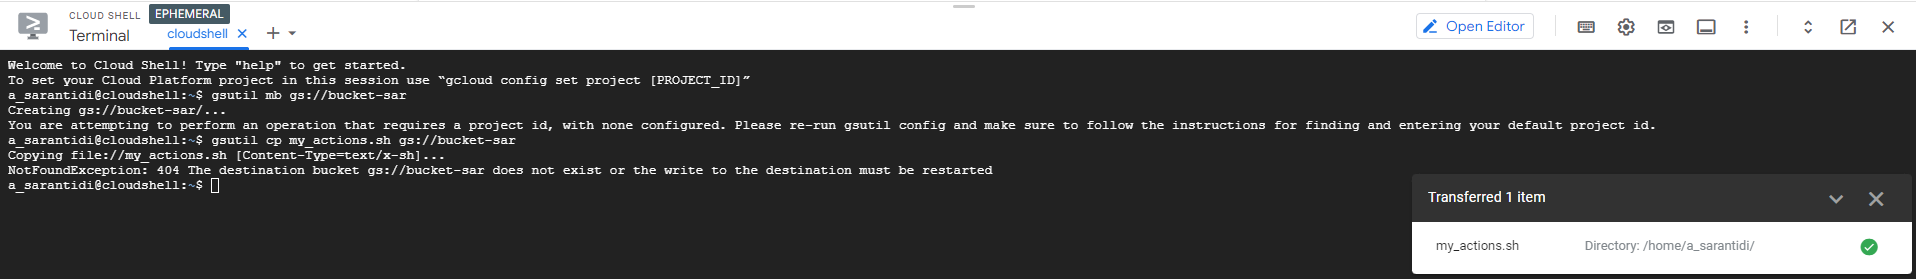

A cluster with the following characteristics was created.

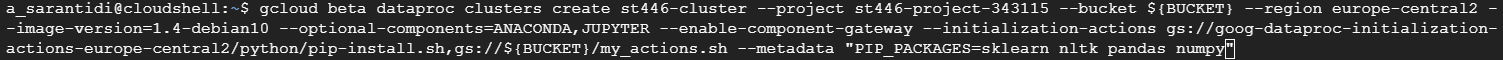

The dataset was loaded into Hadoop in the same way that was shown in notebook 'Graph_analysis.ipynb

## Execution

In [10]:
from __future__ import print_function
from pyspark.sql import SQLContext
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql.functions import col, lit, when

import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS

import numpy as np
from time import time
import random
import os
import sys
from scipy.sparse import csr_matrix
from scipy import sparse
from numpy.random import rand
from numpy import savetxt

In [5]:
# This is necessary for saving partial computations (checkpoints)
# Change to reflect your bucket name
sc.setCheckpointDir("gs://bucket-sar/tmp/") 

In [6]:
# this is the path inside our Dataproc cluster's master node
spark_home = "file:///usr/lib/spark"

In [96]:
#Load the usersha1-artmbid-artname-plays.tsv dataset

folder = "hdfs:///usersha1/" 

# Schema for the dataset
schema = StructType([
    StructField("user-mboxsha1", StringType(), True),    
    StructField("musicbrainz-artist-id", StringType(), True),
    StructField("artist-name", StringType(), True),
    StructField("plays", LongType(), True)
])

# loading the dataset
play_df_org = spark.read.csv(folder +"usersha1-artmbid-artname-plays.tsv", header=True, schema=schema, sep='\t')

fraction = 0.0001
play_df = play_df_org.sample(False, fraction,30)
play_df = play_df.na.drop(how="any")

In [97]:
#Rename columns so that they don't have special characters
play_df = play_df.withColumnRenamed("musicbrainz-artist-id","mus_artist_id").\
withColumnRenamed("user-mboxsha1","user_id").\
withColumnRenamed("artist-name","artist_name")

### Transform ids to integers


In [98]:
play_df.createOrReplaceTempView("play_df")
users = spark.sql(""" SELECT user_Id, ROW_NUMBER() OVER(ORDER BY user_Id ASC) AS user
                        FROM (SELECT user_Id from play_df group by 1)
                    """)
users.createOrReplaceTempView("users")

artists = spark.sql(""" SELECT artist_name, ROW_NUMBER() OVER(ORDER BY artist_name ASC) AS artist
                        FROM (SELECT artist_name from play_df group by 1)
                    """)
artists.createOrReplaceTempView("artists")


plays = spark.sql("""SELECT p.*, user, artist
                    FROM play_df as p
                    JOIN users as u on p.user_Id = u.user_Id
                    JOIN artists as a on p.artist_name = a.artist_name
                     """)
plays.createOrReplaceTempView("plays")


plays_sgd_in = spark.sql("""SELECT user, artist, plays
                    FROM plays as p
                     """)
plays_sgd_in.createOrReplaceTempView("plays_sgd_in")

## Stochastic Gradient Descent algorithm:

We consider rating to be the number of plays.

In [99]:
# number of iterations
I = 5
# number of workers
B = 2
# number of latent factors
LF = 11
# beta value
beta = 1
# lambda input
lambda_input = 0.1

In [100]:
# changed the data to sparse matrix formation to calculate Reconstruction error
def CSV_to_sparse(file):
    # create different lists 
    row_indices = []
    col_indices = []
    data_rating = []

    lines = file.collect()
    for line in lines:
        line_array = line.split(",")
        row_indices.append(int(line_array[0]) - 1)
        col_indices.append(int(line_array[1]) - 1)
        data_rating.append(float(line_array[2]))

    return csr_matrix((data_rating, (row_indices, col_indices)))

def SGD_update(t):
    # get all three items
    V_block, W_block, H_block = t[1]
    # converted for easy manipulation
    W_dict = dict(W_block)
    H_dict = dict(H_block)
    # number of SGD updates for current worker or n'
    iter = 0
    # for each item in each tuple
    for (user_id, artist_id, rating) in V_block:
        # increse n'
        iter += 1
        # SGD stepsize
        epsilon = pow(100 + total_update_count + iter, -1 * beta)  

        Wi = W_dict[user_id]
        Hj = H_dict[artist_id]

        # LNZSL
        loss = -2*(rating - np.dot(Wi,Hj))
        H_dict[artist_id]  = Hj - epsilon*(2*lambda_input/Ni[artist_id]*Hj + loss*Wi)
        W_dict[user_id] = Wi - epsilon*(2*lambda_input/Nj[user_id]*Wi + loss*Hj)
    return (W_dict.items(), H_dict.items())

# l2 loss
def L2_loss(V, W, H):
    # temporaray W and H to calculate the difference
    V_temp = W.dot(H)
    # number of non zero index
    nz_index = V.nonzero()
    # calcualte the difference after calulating list into array
    difference = np.asarray(V[nz_index] - V_temp[nz_index])
    # calculate the sum
    sum = np.sum(difference ** 2)
    return sum

In [101]:
def sgd (df_in, part, F, I):
    #Start computing the performance
    t0 = time()

    #if __name__ == "__main__":
    global random_num, total_update_count
    global Nj, Ni
    l2loss_per_iter ={}
    # make the spark context
    sc = SparkContext.getOrCreate()

    # transform the input df into an rdd    
    plays_sgd_rdd = df_in.rdd.repartition(part)

    #cache the rdd so that it is in the memory
    plays_sgd_rdd.cache()

    #make the values of the 3 columns to be 1 string
    plays_sgd_rdd = plays_sgd_rdd.map(lambda x: (str(x[0]) + ',' + str(x[1]) + ',' + str(x[2])))

    # data in tuple form
    ratings_data = plays_sgd_rdd.map(lambda x: [int(y) for y in x.split(',')])


    # calculate l2 loss
    Nj = ratings_data.keyBy(lambda x: x[0]).countByKey()
    Ni = ratings_data.keyBy(lambda x: x[1]).countByKey()

    # Get the number of users and artists
    num_users, num_artists= ratings_data.reduce(lambda x,y: (max(x[0],y[0]),max(x[1],y[1])))    

    # global varibale to keep track of all previous iterations
    total_update_count = 0

    # initilized W and H with same number of values as of number of users and artists
    # randomizing according to factors provided by the user
    W = sc.parallelize(range(num_users + 1)).map(lambda x: (x, rand(F)))
    H = sc.parallelize(range(num_artists + 1)).map(lambda x: (x, rand(F)))


    # initialize number of iterations
    iterations = 0

    # run till number of iterations
    while iterations < I:
        # random number to select startum
        random_num = random.randrange(999)

        # get blocks of parameters Wib and Hib in RDDs
        #--A BlockMatrix is a distributed matrix backed by an RDD of MatrixBlocks, where a MatrixBlock is a tuple of ((Int, Int), Matrix),
        #where the (Int, Int) is the index of the block, and Matrix is the sub-matrix at the given index with size rowsPerBlock x
        #colsPerBlock. BlockMatrix supports methods such as add and multiply with another BlockMatrix.--
        Wib = W.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))
        Hib = H.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))

        # get diagonal blocks
        V_diag = ratings_data.filter(lambda x: 
                                    ((hash(str(x[0]) + str(random_num)) % B) == (hash(str(x[1]) + str(random_num)) % B)))   

        # get blocks of data matrices
        V_blocks = V_diag.keyBy(lambda x: (hash(str(x[0]) + str(random_num)) % B))


        # to keep track of total number of SGD updates made across all strata
        curr_upd_count = V_diag.count()


        # group Vblock, Wib and Hib to send it to SGD update
        V_group = V_blocks.groupWith(Wib, Hib).coalesce(B)

        # get the updated W and H after SGD update
        new_WH = V_group.map(SGD_update)

        # separated W and H
        W = new_WH.flatMap(lambda x: x[0])
        H = new_WH.flatMap(lambda x: x[1])

        # updated W and H which are sequence of arrays to form one single array
        W_result_temp = np.vstack(W.sortByKey().map(lambda x: x[1]).collect()[1:])
        H_result_temp = np.vstack(H.sortByKey().map(lambda x: x[1]).collect()[1:])

        # transpose to multiple W and H
        H_result = H_result_temp.T

        # update total updates or 'n' in algorithm 2 after each iteration
        total_update_count += curr_upd_count

        # print the l2 loss for algorithm
        # send sparse matrix, W and H to find the loss
        l2 = L2_loss(CSV_to_sparse(plays_sgd_rdd), W_result_temp, H_result)
        l2loss_per_iter[(F, iterations+1)] = l2
        # increment the loop
        iterations += 1

    # L2 Loss after number of iterations
    #print (L2_loss(CSV_to_sparse(plays_sgd_rdd), W_result_temp, H_result))
    l2 = l2
    M = sc.parallelize(W_result_temp.dot(H_result))

    t1 = time()
    comp_time = (t1 - t0)
    #computationTime_sgd_part[part +1] = (t1 - t0)

    #l2loss_part[part +1] = L2_loss(CSV_to_sparse(plays_sgd_rdd), W_result_temp, H_result)
    return M, l2, comp_time, l2loss_per_iter

In [102]:
#SGD for different number of partitions

#initialize dictionaries to store metrics
l2loss_part = {}
computationTime_sgd_part = {}
sgd_out = {}
F = 2 #testing different number of latent factors
P = 4 #test different number of partitions (from 1 to 4)    

for part in range(1,P+1):
    sgd_out[part] = sgd(plays_sgd_in, part, F, I)
    l2loss_part[part]= sgd_out[part][1]
    computationTime_sgd_part[part] = sgd_out[part][2]

In [103]:
#SGD for different number of latent factors
#initialize dictionaries to store metrics
l2loss = {}
computationTime_sgd = {}
l2loss_per_iter ={}

P = 4 #test different number of partitions (from 1 to 4)    

# testing different number of latent factors
for F in range(1,LF):
    sgd_out[F] = sgd(plays_sgd_in, P, F, I)   
    computationTime_sgd[F] = sgd_out[F][2]  
    l2loss[F] = sgd_out[F][1]
    l2loss_per_iter.update(sgd_out[F][3])

### PLOTS

### Number of iterations vs l2Loss

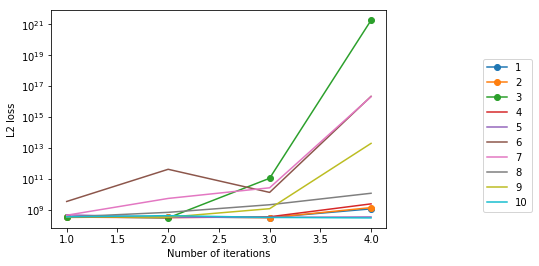

In [104]:
# plotting performance x number of latent factors
# unique entries:
numberLatentFactors = list(set([x[0] for x in l2loss_per_iter.keys()]))
maxiter=range(1,I)

for numberLatentFactors in range(1,LF):
    currenrmse = [l2loss_per_iter[numberLatentFactors,m] for m in maxiter]
    if numberLatentFactors in [1,2,3]:
        plt.plot(maxiter,currenrmse,'o-',label=numberLatentFactors)
    else:
        plt.plot(maxiter,currenrmse,label=numberLatentFactors)
    plt.xlabel('Number of iterations')
    plt.ylabel('L2 loss')

plt.yscale('log')
plt.legend(loc='upper right', bbox_to_anchor=(1.45, 0.8))
plt.show()

### Number of latent factors vs computation time

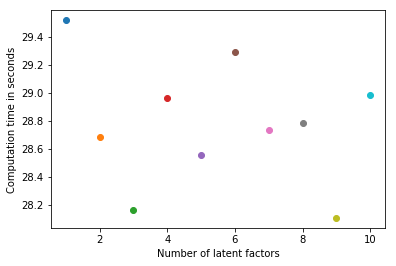

In [105]:
# plotting performance of the algorithm against the number of latent factors

# unique entries:
#numberLatentFactors = list(set([x for x in computationTime_sgd.keys()]))

for numberLatentFactors in range(1, LF):
    currenrmse = [computationTime_sgd[numberLatentFactors] ]
    plt.plot(numberLatentFactors, currenrmse,'o-')
    plt.xlabel('Number of latent factors')
    plt.ylabel('Computation time in seconds')

plt.show()

### Number of latent factors vs l2loss

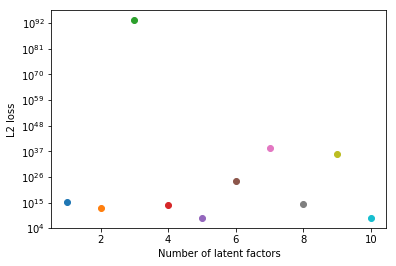

In [106]:
# plotting performance of the algorithm against the number of latent factors

# unique entries:
for numberLatentFactors in range(1,LF):
    currenrmse = [l2loss[numberLatentFactors] ]
    plt.plot(numberLatentFactors, currenrmse,'o-')
    plt.xlabel('Number of latent factors')
    plt.ylabel('L2 loss')

plt.yscale('log')
plt.show()

### Computation time vs partitions

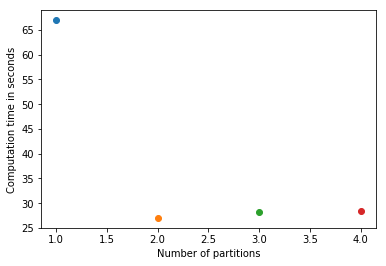

In [107]:
# plotting performance of the algorithm against the number of partitions
for numberPartitions in range(1, P+1):
    currenrmse = [computationTime_sgd_part[numberPartitions] ]
    plt.plot(numberPartitions, currenrmse,'o-')
    plt.xlabel('Number of partitions')
    plt.ylabel('Computation time in seconds')

plt.show()

### Number of partitions vs l2loss

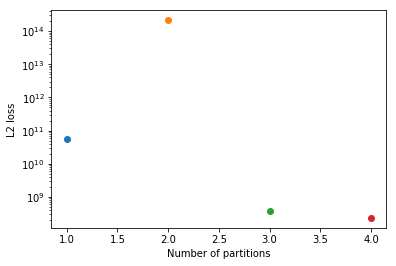

In [108]:
# plotting performance of the algorithm against the number of partitions
for numberPartitions in range(1,P +1):
    currenrmse = [l2loss_part[numberPartitions] ]
    plt.plot(numberPartitions, currenrmse,'o-')
    plt.xlabel('Number of partitions')
    plt.ylabel('L2 loss')

plt.yscale('log')
plt.show()

In [125]:
#Recommendations from a model with 3 Latent Factors
recommendations = sgd_out[3][0]

In [128]:
#Print the recommendations for the first 3 users:
recommendations.take(3)

[array([1.47033543, 1.52609801, 2.21846561, ..., 0.49267989, 0.93131548,
        2.31927307]),
 array([1.73193943, 1.82497864, 2.64860399, ..., 0.56369383, 1.16041287,
        2.86438555]),
 array([1.55584292, 1.64590202, 2.38769627, ..., 0.50243715, 1.05744378,
        2.60452382])]